#k-means

W tym zadaniu chcemy dokonać kompresji zbioru danych $X$ za pomocą $k$-punktów (centroidów), tak,  że zastąpienie najbliższym centroidem ma minimnalny błąd średniokwadratowy.

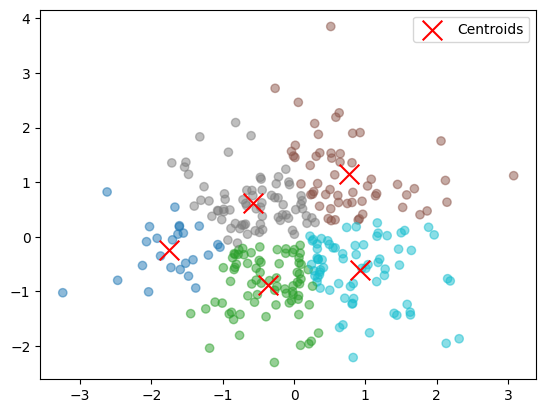

In [ ]:
import numpy as np

# Funkcja implementująca algorytm k-means
def kmeans(X, k, max_iters=100):
    # Inicjalizacja centroidów losowo z próbek danych
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Przypisanie każdego punktu do najbliższego centroidu
        distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        # Aktualizacja centroidów jako średnia punktów w klastrze
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Sprawdzenie warunku stopu (jeśli centroidy się nie zmieniają)
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return labels, centroids

# Przykładowe dane
np.random.seed(42)
X = np.random.randn(300, 2)  # 300 punktów w 2D

# Uruchomienie k-means dla k=3
labels, centroids = kmeans(X, k=5)

# Wizualizacja wyników
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.legend()
plt.show()


## k-means
implementacja loss za pomocą sieci


Epoch 0, Loss: 0.4553
Epoch 20, Loss: 0.3023
Epoch 40, Loss: 0.2971
Epoch 60, Loss: 0.2966
Epoch 80, Loss: 0.2965
Epoch 100, Loss: 0.2965
Epoch 120, Loss: 0.2965
Epoch 140, Loss: 0.2965
Epoch 160, Loss: 0.2965
Epoch 180, Loss: 0.2965
Trening zakończony.
Finalne centroidy: [[ 0.22446004 -0.97570014]
 [ 1.5063614  -0.4544238 ]
 [-0.33384752 -0.23539104]
 [ 0.67189     0.3948747 ]
 [-0.87397385  1.6794306 ]
 [-1.0594084  -1.041296  ]
 [-0.7002882   0.78467077]
 [ 0.69740623  1.5306001 ]
 [-2.1992073   0.0947616 ]
 [ 0.21720049 -2.6137447 ]]


<ipython-input-2-afd2b7c27be4>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', num_clusters).colors  # Dynamiczne przypisanie kolorów


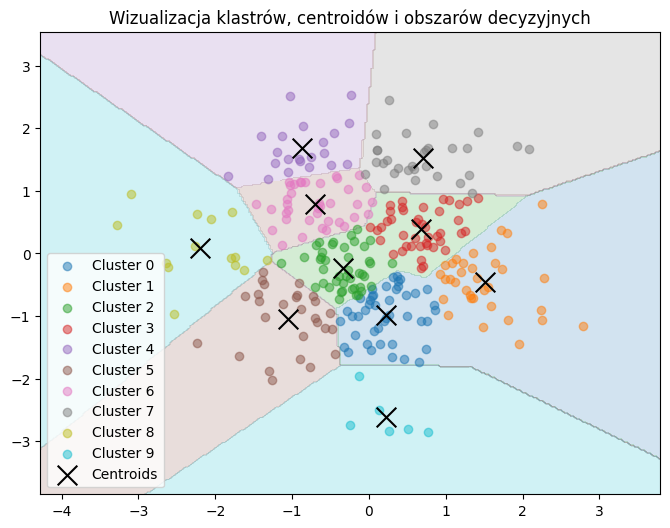

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Generowanie przykładowych danych
num_points = 300
num_clusters = 10  # Można dowolnie zmieniać liczbę klastrów
dim = 2

data = torch.randn(num_points, dim)

# Definicja prostej sieci neuronowej modelującej centroidy
class ClusterModel(nn.Module):
    def __init__(self, num_clusters, dim):
        super(ClusterModel, self).__init__()
        self.centroids = nn.Parameter(torch.randn(num_clusters, dim))

    def forward(self, x):
        # Obliczanie odległości euklidesowej od centroidów
        distances = torch.cdist(x, self.centroids)  # [num_points, num_clusters]
        assignments = torch.argmin(distances, dim=1)  # Indeksy najbliższych centroidów
        return assignments

# Funkcja straty - minimalizujemy sumę kwadratów odległości od przypisanych centroidów
def loss_function(data, centroids):
    distances = torch.cdist(data, centroids)  # [num_points, num_clusters]
    min_distances, _ = torch.min(distances, dim=1)
    return min_distances.pow(2).mean()

# Trening modelu
model = ClusterModel(num_clusters, dim)
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 200

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = loss_function(data, model.centroids)
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

print("Trening zakończony.")
print("Finalne centroidy:", model.centroids.detach().numpy())

# Wizualizacja wyników
final_centroids = model.centroids.detach().numpy()
assignments = model(data).detach().numpy()
data_np = data.numpy()

plt.figure(figsize=(8, 6))
colors = plt.cm.get_cmap('tab10', num_clusters).colors  # Dynamiczne przypisanie kolorów
cmap = ListedColormap(colors[:num_clusters])

# Dodanie siatki decyzyjnej
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)
grid_assignments = model(grid_tensor).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, grid_assignments, alpha=0.2, cmap=cmap)

# Rysowanie punktów i centroidów
for i in range(num_clusters):
    cluster_points = data_np[assignments == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], alpha=0.5, label=f'Cluster {i}')
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='black', marker='x', s=200, label='Centroids')

plt.legend()
plt.title("Wizualizacja klastrów, centroidów i obszarów decyzyjnych")
plt.show()
